###### import tensorflow as tf
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))


In [1]:
import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import os
import csv 

import keras
import tensorflow as tf
from keras import backend
from keras.backend import set_session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, LeakyReLU, Conv2DTranspose, ReLU
from tensorflow.keras.optimizers import Adam
from keras.layers import Reshape
from keras import layers
import datetime

from keras import initializers


config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # fraction of memory
config.gpu_options.visible_device_list = "0"

set_session(tf.compat.v1.Session(config=config))

2022-11-29 08:26:55.148163: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 08:26:55.271195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:26:55.416148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:26:55.417593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [2]:
path = '/kaggle/input/face-mask-dataset-1'
xname = 'real_with_mask.pickle'
yname = 'real_with_out_mask.pickle'
pickle_in = open(os.path.join(path,xname),"rb")
x = pickle.load(pickle_in)

pickle_in = open(os.path.join(path,yname),"rb")
y = pickle.load(pickle_in)

print(x.shape)
print(y.shape)
print(type(x))

(5000, 128, 128, 1)
(5000, 128, 128, 1)
<class 'numpy.ndarray'>


In [3]:
fields = ["Gan Loss", "Disc loss", "Gen Loss" , "Test Gan Loss", "Test Disc Loss"]
rows = []
print(rows)

[]


(5000, 64, 64, 1)
(5000, 64, 64, 1)


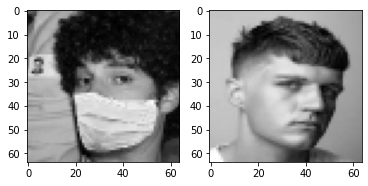

In [4]:
#Resize the image from 200 * 200 to 64 * 64

from skimage.transform import resize
x = resize(x, (len(x),64, 64,1), anti_aliasing=False)
y = resize(y, (len(y),64,64,1), anti_aliasing=False)

# Print the shape after resize
print(x.shape)
print(y.shape)

#Draw the image to be sure occluded image is the same as the ground truth one
fig=plt.figure(figsize=(6, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(x[4,:,:,0],cmap="gray")
fig.add_subplot(1, 2, 2)
plt.imshow(y[4,:,:,0],cmap="gray")
np.random.shuffle(x)
np.random.shuffle(y)

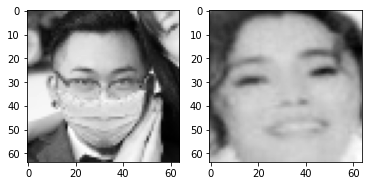

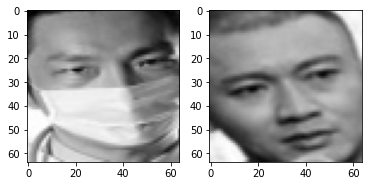

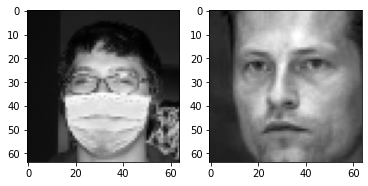

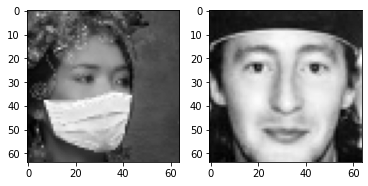

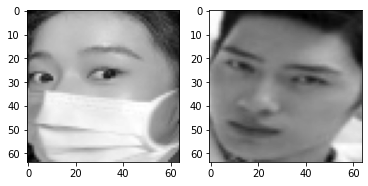

In [5]:
for i in range(5):
    fig=plt.figure(figsize=(6, 6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(x[i,:,:,0],cmap="gray")
    fig.add_subplot(1, 2, 2)
    plt.imshow(y[i,:,:,0],cmap="gray")

In [6]:
print(x.shape)
print(y.shape)

(5000, 64, 64, 1)
(5000, 64, 64, 1)


In [7]:
#print pixel values to be sure occluded and ground truth images are aligned
print(x[2,50:52,50:52,0])
print(y[2,50:52,50:52,0])

[[0.0745098  0.04803922]
 [0.04215686 0.04901961]]
[[0.43431373 0.45686275]
 [0.40882353 0.42941176]]


In [8]:
#Here is the function to create a generator. 
def creategen():
  generator = Sequential()


  generator.add(Conv2D(64, (5,5) , strides = (2,2), input_shape = x.shape[1:] , padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))


  generator.add(Conv2D(128, (5,5) ,  strides = (2,2),padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))

  
  generator.add(Conv2D(256, (5,5) ,  strides = (2,2), padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))

  generator.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  
  generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  
  generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation = "tanh"))
  

  return generator

generator = creategen()


2022-11-29 08:27:12.575581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:27:12.576781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:27:12.577666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:27:12.578515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:27:12.579335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [9]:
#Here is the function to create a discriminator. 
def createdisc():
  discriminator = Sequential()

  discriminator.add(Conv2D(64, (5,5) , strides = (2,2), input_shape = x.shape[1:] , padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))


  discriminator.add(Conv2D(128, (5,5) ,  strides = (2,2),padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))

  
  discriminator.add(Conv2D(256, (5,5) ,  strides = (2,2), padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))

  
  discriminator.add(Flatten())
  discriminator.add(Dense(1))
  
  return discriminator


discriminator = createdisc()


In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0

In [11]:
# Learning rate of discriminator is advised to be the double of the generator. 
# train the generator two times in each step of training. First is with Gan loss, second is with L2 loss.
# That is why we use x4 learning rate in discriminator.

opt_disc = Adam(lr=0.00004)
discriminator.trainable = True
discriminator.compile(loss = "binary_crossentropy", optimizer = opt_disc)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)      

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
opt_gen = Adam(lr=0.00002)
generator.compile(loss="mean_squared_error", optimizer = opt_gen)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0

In [13]:
#Here is the function to create a GAN model.

def creategan(generator,discriminator):
  gan = Sequential()
  gan.add(generator)
  discriminator.trainable = False
  gan.add(discriminator)
  return(gan)

gan = creategan(generator,discriminator)

In [14]:
opt_gan = Adam(lr=0.00001)
gan.compile(loss = "binary_crossentropy", optimizer = opt_gan)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         2054208   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1044225   
Total params: 3,098,433
Trainable params: 2,052,928
Non-trainable params: 1,045,505
_________________________________________________________________


In [15]:
# This is to save models. It saves both the architectures and the weights.

def save_models(gan,discriminator,generator,path,epoch):
  datenow = str(datetime.datetime.now().strftime('%m-%d-%H:%M'))
  gan.save_weights(os.path.join(path,"{0}_wgan_{1}.h5".format(epoch,datenow)))
  gan.save(os.path.join(path,"{0}_mgan_{1}.h5".format(epoch,datenow)))


  discriminator.save_weights(os.path.join(path,"{0}_wd_{1}.h5".format(epoch,datenow)))
  discriminator.save(os.path.join(path,"{0}_md_{1}.h5".format(epoch,datenow)))


  generator.save_weights(os.path.join(path,"{0}_wg_{1}.h5".format(epoch,datenow)))
  generator.save(os.path.join(path,"{0}_mg_{1}.h5".format(epoch,datenow)))
  


In [16]:
def test(x,y):
  gan_inp_t = x  
  gan_label_t = np.ones([len(gan_inp_t)])
  gan_predict_t = None
  
  disc_inp_t = None


  disc_label_t = np.zeros([len(gan_inp_t)*2])
  disc_label_t[len(gan_inp_t):] = 1
  
  disc_predict_t = None
  

  gen_predict_t = generator.predict(gan_inp_t)


  disc_inp_t = np.concatenate((gen_predict_t,y), axis = 0)
  disc_predict_t = discriminator.predict(disc_inp_t)

  d_loss_t = discriminator.test_on_batch(disc_inp_t,disc_label_t)

  gan_loss_t = gan.test_on_batch(gan_inp_t,gan_label_t)
  
  return (gan_loss_t, d_loss_t)

In [17]:
# I use isolated mini batches to slow down discriminator:
# I also use smooth/noisy labels proposed by Salimans et al 2016
# Reference: https://github.com/soumith/ganhacks



def train(x,y, nepoch, model_save_path = "./"):

  gen_predict = None
  
  #Initialize the inputs and the labels.
  gan_inp = x 
  gan_inp_size = 64
  gan_label = np.ones(64)
  gan_predict = None
  
  disc_inp = None


  disc_label = np.zeros(64*2)
  disc_label[64:] = 1
  
  disc_predict = None
  

  sess = tf.compat.v1.Session()

  
  
  for epoch in range(nepoch):

    for batch_ctr in range(65):

      #Generator makes a prediction.
      gen_predict = generator.predict(gan_inp[batch_ctr*gan_inp_size:(batch_ctr+1)*gan_inp_size])
    

      #Minibatch isolation and label smoothing is done here:
      
      if(epoch%2==0):
        disc_inp = gen_predict
        #disc_label = np.zeros(64) //// I would use this line if there was no noisy labels.
        disc_label = np.random.normal(loc=0, scale=0.10, size=64)
      else:
        disc_inp = y[batch_ctr*64:(batch_ctr+1)*64]
        #disc_label = np.ones(64)  //// I would use this line if there was no noisy labels.
        disc_label = np.random.normal(loc=1, scale=0.10, size=64)


        
      #Initialize a label variable for generator to use it in training.  
      gen_label = y[batch_ctr*64:(batch_ctr+1)*64]
      
      
      #Do one training step. Also assign the losses to variables. We will print them.
      d_loss = discriminator.train_on_batch(disc_inp,disc_label)


      gan_loss = gan.train_on_batch(gan_inp[batch_ctr*gan_inp_size:(batch_ctr+1)*gan_inp_size],
                                    gan_label)

      gen_loss = generator.train_on_batch(gan_inp[batch_ctr*gan_inp_size:(batch_ctr+1)*gan_inp_size],gen_label)
      
    
    
    if epoch == nepoch - 1:
      save_models(gan,discriminator,generator, model_save_path,epoch+1)  
      print("MODEL SAVED")
      
    
    # Test images are the images after the 4160th image. It makes 311 test images.
    (tgan,tdisc)= test(x[4160:],y[4160:])
    
    rows.append([gan_loss,d_loss,gen_loss,tgan,tdisc])
    print("Epoch: {2} Gan Loss: {0}       Disc Loss: {1}        Gen Loss: {3}".format(gan_loss,d_loss,epoch+1,gen_loss))
    print("Epoch: {2} Test Gan Loss: {0}  Test Disc Loss: {1} \n\n\n".format(tgan,tdisc,epoch+1))

In [18]:
# Checking lengths of the input and ground truth arrays. Also checking if normalization is done.
print(len(x),len(y))
print(x.max(),x.min())
print(y.max(),y.min())

5000 5000
1.0 0.0
1.0 0.0


In [19]:
model_path = "/kaggle/input/weight-4100-epochs"

epoch = 300

# #generator = creategen()
generator.load_weights(os.path.join(model_path,"{0}_wg_11-29-07_22.h5".format(epoch)))
# #discriminator = createdisc()
discriminator.load_weights(os.path.join(model_path,"{0}_wd_11-29-07_22.h5".format(epoch)))

# #gan = creategan(generator,discriminator)
gan.load_weights(os.path.join(model_path,"{0}_wgan_11-29-07_22.h5".format(epoch)))

print("4100 epochs weight loaded")

4100 epochs weight loaded


In [20]:

model_save_path = './'
batch_size = 64
train(x,y, 300 ,model_save_path)


2022-11-29 08:27:14.898195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:27:14.900073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:27:14.901694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:27:14.902474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:27:14.903667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch: 1 Gan Loss: 0.0       Disc Loss: 15.150921821594238        Gen Loss: 0.05955197662115097
Epoch: 1 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 2 Gan Loss: 0.0       Disc Loss: -0.06823784112930298        Gen Loss: 0.05918780714273453
Epoch: 2 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 3 Gan Loss: 0.0       Disc Loss: 15.361682891845703        Gen Loss: 0.05825817584991455
Epoch: 3 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 4 Gan Loss: 0.0       Disc Loss: -0.12554767727851868        Gen Loss: 0.05811504274606705
Epoch: 4 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 5 Gan Loss: 0.0       Disc Loss: 15.045504570007324        Gen Loss: 0.05762358009815216
Epoch: 5 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 6 Gan Loss: 0.0       Disc Loss: -0.060589395463466644        Gen Loss: 0.058104947209358215
Epoch: 6 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 7

2022-11-29 08:55:37.049508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch: 147 Gan Loss: 0.0       Disc Loss: 15.071924209594727        Gen Loss: 0.05032643675804138
Epoch: 147 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 148 Gan Loss: 0.0       Disc Loss: 0.388217031955719        Gen Loss: 0.05054686963558197
Epoch: 148 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 149 Gan Loss: 0.0       Disc Loss: 15.118156433105469        Gen Loss: 0.04977601766586304
Epoch: 149 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 150 Gan Loss: 0.0       Disc Loss: -0.27837473154067993        Gen Loss: 0.05100654065608978
Epoch: 150 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 151 Gan Loss: 0.0       Disc Loss: 15.36666488647461        Gen Loss: 0.049500465393066406
Epoch: 151 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 152 Gan Loss: 0.0       Disc Loss: -0.40561702847480774        Gen Loss: 0.05092882364988327
Epoch: 152 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302

2022-11-29 09:02:23.549355: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch: 183 Gan Loss: 0.0       Disc Loss: 15.241065979003906        Gen Loss: 0.048509757965803146
Epoch: 183 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 184 Gan Loss: 0.0       Disc Loss: 0.1438947319984436        Gen Loss: 0.04819216579198837
Epoch: 184 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 185 Gan Loss: 0.0       Disc Loss: 15.187161445617676        Gen Loss: 0.04973166063427925
Epoch: 185 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 186 Gan Loss: 0.0       Disc Loss: 0.2902858853340149        Gen Loss: 0.04789971560239792
Epoch: 186 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 187 Gan Loss: 0.0       Disc Loss: 15.04601001739502        Gen Loss: 0.04858774691820145
Epoch: 187 Test Gan Loss: 0.0  Test Disc Loss: 7.6246185302734375 



Epoch: 188 Gan Loss: 0.0       Disc Loss: -0.12690025568008423        Gen Loss: 0.04837054759263992
Epoch: 188 Test Gan Loss: 0.0  Test Disc Loss: 7.62461853027

In [21]:
filename = "loss.csv"
     
with open(filename, 'w', newline='') as csvfile: 
    csvwriter = csv.writer(csvfile) 
        
    csvwriter.writerow(fields) 
        
    csvwriter.writerows(rows)

In [22]:
# model_path = "/kaggle/input/weight-3800-epochs"

# epoch = 300

# # #generator = creategen()
# generator.load_weights(os.path.join(model_path,"{0}_wg_11-28-12_08.h5".format(epoch)))
# # #discriminator = createdisc()
# discriminator.load_weights(os.path.join(model_path,"{0}_wd_11-28-12_08.h5".format(epoch)))

# # #gan = creategan(generator,discriminator)
# gan.load_weights(os.path.join(model_path,"{0}_wgan_11-28-12_08.h5".format(epoch)))

# print("3800 epochs weight loaded")

In [23]:
# # Making predictions and drawing them.
# # First row: Occluded images
# # Second row: Ground Truth images
# # Third row: Predictions

# import datetime
# plot_path = "./"

# a = 6770
# b = 6780
# pred=generator.predict(x[a:b])

# fig = plt.figure(figsize = (20,10))
# for ctr in range(10):
#   fig.add_subplot(3,10,ctr+1)
#   plt.imshow(np.reshape(x[a + ctr],(64,64)),  cmap = "gray")

  

# for ctr in range(10):
#   fig.add_subplot(3,10,(10 + ctr + 1))
#   plt.imshow(np.reshape(y[a + ctr]/255,(64,64)),  cmap = "gray")  


# for ctr in range(10):
#   fig.add_subplot(3,10,(20 + ctr + 1))
#   plt.imshow(np.reshape(pred[ctr],(64,64)),  cmap = "gray")
  
# plt.savefig(os.path.join(plot_path,str(datetime.datetime.now().strftime('%m-%d-%H:%M'))))

In [24]:
# import pandas as pd
# from matplotlib import pyplot as plt

# figure, axis = plt.subplots(1, 2)

# columns = ["Epochs", "GanLoss"]

# df = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[0].plot(df.Epochs, df.GanLoss)
# axis.flat[0].set(xlabel = 'Epochs' , ylabel = 'GanLoss')
# axis[0].set_title('6050 epoch GAN Loss')

# df1 = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[1].plot(df1.Epochs, df1.GanLoss)
# axis.flat[1].set(xlabel = 'Epochs' , ylabel = 'GanLoss')

# axis[1].set_title('6050 epoch GAN Loss')

In [25]:

# figure, axis = plt.subplots(1, 2)

# columns = ["Epochs", "GenLoss"]
# df = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[0].plot(df.Epochs, df.GenLoss)
# axis.flat[0].set(xlabel = 'Epoch' , ylabel = 'GenLoss')
# axis[0].set_title('6050 epoch Gen Loss')

# df1 = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[1].plot(df1.Epochs, df1.GenLoss)
# axis.flat[1].set(xlabel = 'Epoch' , ylabel = 'GenLoss')

# axis[1].set_title('6050 epoch Gen Loss')

In [26]:

# figure, axis = plt.subplots(1, 2)
# columns = ["Epochs", "DiscLoss"]
# df = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[0].plot(df.Epochs, df.DiscLoss)
# axis.flat[0].set(xlabel = 'Epochs' , ylabel = 'DiscLoss')
# axis[0].set_title('6050 epoch Disc Loss')

# df1 = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[1].plot(df1.Epochs, df1.DiscLoss)
# axis.flat[1].set(xlabel = 'Epoch' , ylabel = 'DiscLoss')

# axis[1].set_title('6050 epoch Disc Loss')

In [27]:
# import cv2
# import matplotlib.image as mpimg
# img = mpimg.imread("/kaggle/input/vijay-2000/vijay mask.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# img.shape
# plt.imshow(img)
# from skimage.transform import resize

# img = resize(img, (64 , 64), anti_aliasing=False)
# plt.imshow(img , cmap = 'gray')

In [28]:
# import datetime
# plot_path = "./"
# img = np.expand_dims(img, axis=-1)
# print(img.shape)

In [29]:
# img = np.expand_dims(img, axis=0)
# print(img.shape)
# pred = generator.predict(img)
# print(pred.shape)
# plt.imshow(np.reshape(pred, (64,64)), cmap = "gray")